# Preprocessing Data


Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


Data Overview

In [2]:
data_path = "/Users/ByongLee/Desktop/fer2013.csv"
image_size = (48,48)

In [3]:
data = pd.read_csv(data_path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
data['emotion'].value_counts(sort=False).reset_index()

,index,emotion
0,0,4953
1,1,547
2,2,5121
3,3,8989
4,4,6077
5,5,4002
6,6,6198


In [7]:
emotion_map = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emo_distribution = data.emotion.value_counts(sort=False).reset_index()
emo_distribution.columns = ['emotion','number']
emo_distribution['emotion'] = emo_distribution['emotion'].map(emotion_map)
print(emo_distribution)

    emotion  number
0     Angry    4953
1   Disgust     547
2      Fear    5121
3     Happy    8989
4       Sad    6077
5  Surprise    4002
6   Neutral    6198


Observe some images from data

In [8]:
def pics_from_row(row):
    pixels,emotion = row['pixels'], emotion_map[row['emotion']]
    pic = np.array(pixels.split())
    pic = pic.reshape(48,48)
    picture = np.zeros((48,48, 3))
    picture[:, :, 0] = pic
    picture[:, :, 1] = pic
    picture[:, :, 2] = pic
    return np.array([picture.astype(np.uint8), emotion])


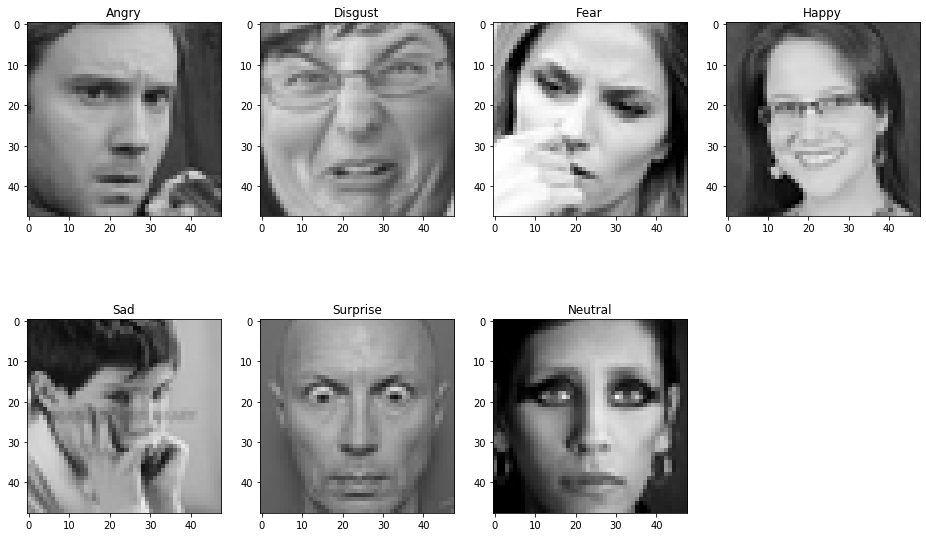

In [9]:
plt.figure(0, figsize=(16,10))
for i in range (1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    pic = pics_from_row(face)
    plt.subplot(2,4,i)
    plt.imshow(pic[0])
    plt.title(pic[1])
    
plt.show()

Extract faces and emotion from dataset


In [10]:
pixels = data['pixels'].tolist()
width,height = 48,48
faces = []
for i in pixels:
    face = [int(pixel) for pixel in i.split(' ')]
    face = np.asarray(face).reshape(width,height)
    face = cv2.resize(face.astype('uint8'),image_size)
    face = face.astype('float32')
    faces.append(face)
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)



In [11]:
faces.shape

(35887, 48, 48, 1)

In [12]:
emotions = pd.get_dummies(data['emotion']).values


Preprocess faces to scale image between -1 and 1, to better fit CNN or future modeling

In [13]:
def preprocessor(x,v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x*2.0
        return x 

faces = preprocessor(faces)    

Split data into test and train dataframes

In [14]:
X_train, X_test,y_train,y_test = train_test_split(faces,emotions,test_size=0.3,shuffle=True)

In [15]:
np.save("faces_train",X_train)

In [16]:
np.save("faces_test",X_test)

In [17]:
np.save("emotions_train",y_train)

In [18]:
np.save("emotions_test",y_test)

In [19]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [20]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

W0821 09:22:33.872255 4712461760 deprecation_wrapper.py:119] From /Users/ByongLee/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 09:22:33.894377 4712461760 deprecation_wrapper.py:119] From /Users/ByongLee/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 09:22:33.898162 4712461760 deprecation_wrapper.py:119] From /Users/ByongLee/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 09:22:33.958177 4712461760 deprecation_wrapper.py:119] From /Users/ByongLee/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session in